#RNN - Training Problems and Adding Depth

##What you'll learn from this lecture
Here are some of the key points for you to take away from this lecture.
1.  When an ordinary RNN is required to learn long sequences it has trouble with gradients exploding or vanishing
2.  You can fix this by clipping the gradients if they get too large
3.  You can stack RNN's in the same way as you stack layers in feed forward networks.  

##Readings
http://jmlr.org/proceedings/papers/v28/pascanu13.pdf - training problems with rnn

https://github.com/pascanur/trainingRNNs/blob/master/RNN.py - pascanu's github code accompanying the paper above (see lines 219 - 244)

http://arxiv.org/pdf/1506.00019v4.pdf - Lipton's excellent survey of RNN

http://arxiv.org/pdf/1312.6026v5.pdf - pascanu and bengio paper on deep RNN architectures

##In class exercise
1.  What are the parameters that might change the training performance of an RNN?
2.  Run sensitivity tests on these parameters.  


##Deep RNN's
Pascanu points out that there are three places where depth might be added to an RNN and shows some empirical results for the corresponding networks.  Here are the equations for the RNN we've been using. 

Nomenclature- 

$u_i$ - Input

$h_i$ - Hidden layer output

$y_i$ - Network output

$W_{..}$ - Weight matrics

$b_{..}$ - Bias vectors

$a(.)$  - activation function

$t_i$ - label

With those definitions the equations for the Elman network you saw in the last lecture are:

$y_i= h*W_{hy} + b_{hy}$

$h_i = a(h_{i-1}W_{hh} + u_iW_{uh} + b_{hh})$

$cost = mean(t - y)^2$

Pascanu's DT(s) network (the b* subfigure in Fig 2)adds a layer that accepts input from input layer and from the $h_{i-1}$ hidden layer and provides input to the $h_i$ layer.  Let's call that layer h2.  Then the equations become:


$y_i= h*W_{hy} + b_{hy}$

$h2_i = a(h_{i-1}W_{hh2} + u_iW_{uh2} + b_{h2h2})$

$h_i = a(h_{i-1}W_{hh} + u_iW_{uh} + h2_i W_{h2h} + b_{hh})$

$cost = mean(t - y)^2$

The code block below shows the modifications necessary to implement this network.  The changes are fairly modest and and mostly localized to the recurrence function that gets called by scan.  



iteration 0: 1.28242719173
iteration 10: 2.1814520359
iteration 20: 10.0960464478
iteration 30: 3.39931869507
iteration 40: 2.53961920738
iteration 50: 5.02067708969
iteration 60: 12.6134777069
iteration 70: 21.8684120178
iteration 80: 7.81989955902
iteration 90: 13.2518558502
iteration 100: 10.9278945923
iteration 110: 1.4697728157
iteration 120: 19.3817806244
iteration 130: 4.69277095795
iteration 140: 4.93961524963
iteration 150: 3.66370368004
iteration 160: 6.11796569824
iteration 170: 9.18711090088
iteration 180: 4.71939945221
iteration 190: 3.8073246479
iteration 200: 2.89441585541
iteration 210: 0.753311157227
iteration 220: 12.8787851334
iteration 230: 1.00186002254
iteration 240: 3.18443202972
iteration 250: 1.61186552048
iteration 260: 0.0607705116272
iteration 270: 6.45117044449
iteration 280: 1.45480668545
iteration 290: 1.54165410995
iteration 300: 0.215069770813
iteration 310: 4.22497177124
iteration 320: 6.48544168472
iteration 330: 1.43369174004
iteration 340: 0.3864347

/home/ubuntu/Applications/anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


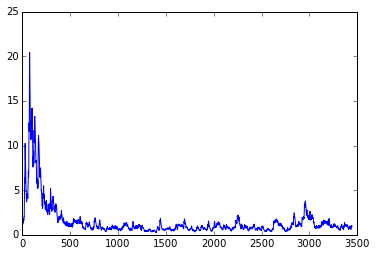

In [1]:
__author__ = 'mike.bowles'
#based on  code from https://gist.github.com/tmramalho/5e8fda10f99233b2370f
import theano
import theano.tensor as T
import numpy as np
import cPickle as pickle
import random
import matplotlib.pyplot as plt
%matplotlib inline


class RNN(object):

    def __init__(self, nin, n_hidden, nout):
        rng = np.random.RandomState(1234)
        W_uh = np.asarray(rng.normal(size=(nin, n_hidden), scale= .01, loc = 0.0), dtype = theano.config.floatX)
        W_hh = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale=.01, loc = 0.0), dtype = theano.config.floatX)
        W_hy = np.asarray(rng.normal(size=(n_hidden, nout), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_hh = np.zeros((n_hidden,), dtype=theano.config.floatX)
        b_hy = np.zeros((nout,), dtype=theano.config.floatX)

        W_hh2 = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale= .01, loc = 0.0), dtype = theano.config.floatX)
        W_uh2 = np.asarray(rng.normal(size=(nin, n_hidden), scale= .01, loc = 0.0), dtype = theano.config.floatX)
        W_h2h = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale= .01, loc = 0.0), dtype = theano.config.floatX)
        b_h2h2 = np.zeros((n_hidden,), dtype=theano.config.floatX)

        self.activ = T.nnet.sigmoid
        lr = T.scalar()
        u = T.matrix()
        t = T.scalar()

        W_uh = theano.shared(W_uh, 'W_uh')
        W_hh = theano.shared(W_hh, 'W_hh')
        W_hy = theano.shared(W_hy, 'W_hy')
        b_hh = theano.shared(b_hh, 'b_hh')
        b_hy = theano.shared(b_hy, 'b_hy')

        h0_tm1 = theano.shared(np.zeros(n_hidden, dtype=theano.config.floatX))

        #theano.printing.debugprint([h0_tm1, u, W_hh, W_uh, W_hy, b_hh, b_hy], print_type=True)
        h, _ = theano.scan(self.recurrent_fn, sequences = u,
                           outputs_info = [h0_tm1],
                           non_sequences = [W_hh, W_uh, W_hy, b_hh, W_hh2, W_uh2, b_h2h2, W_h2h])

        y = T.dot(h[-1], W_hy) + b_hy
        cost = ((t - y)**2).mean(axis=0).sum()

        gW_hh, gW_uh, gW_hy,\
            gb_hh, gb_hy = T.grad(
            cost, [W_hh, W_uh, W_hy, b_hh, b_hy])
        #theano.printing.debugprint([h0_tm1], print_type=True)
        self.train_step = theano.function([u, t, lr], cost,
            on_unused_input='warn',
            updates=[(W_hh, W_hh - lr*gW_hh),
            (W_uh, W_uh - lr*gW_uh),
            (W_hy, W_hy - lr*gW_hy),
            (b_hh, b_hh - lr*gb_hh),
            (b_hy, b_hy - lr*gb_hy)],
            allow_input_downcast=True)

    def recurrent_fn(self, u_t, h_tm1, W_hh, W_uh, W_hy, b_hh, W_hh2, W_uh2, b_h2h2, W_h2h):
        h2 = self.activ(T.dot(h_tm1, W_hh2) + T.dot(u_t, W_uh2) + b_h2h2)
        h_t = self.activ(T.dot(h_tm1, W_hh) + T.dot(u_t, W_uh) + T.dot(h2, W_h2h) + b_hh)
        return h_t

if __name__ == '__main__':

    (xlist, ylist) = pickle.load(open('stockTT.bin', 'rb'))
    nInputs = len(xlist[0])
    x = np.array(xlist, dtype = theano.config.floatX)
    y = np.array(ylist, dtype = theano.config.floatX)
    nHidden = 20
    nOutputs = 1
    rnn = RNN(nInputs, nHidden, nOutputs)
    lr = 0.01
    e = 1.0
    nPasses = 1
    vals = []
    for i in range(nPasses):
        for j in range(len(x)):
            u = np.asarray(xlist[j], dtype = theano.config.floatX).reshape((1,nInputs))
            t = y[j]

            c = rnn.train_step(u, t, lr)
            if j%10==0: print "iteration {0}: {1}".format(j, np.sqrt(c))
            e = 0.1*np.sqrt(c) + 0.9*e
            vals.append(e)
    plt.plot(vals)
    plt.show()


##Q's
1.  make some parametric changes to the code to see if you can improve performance.
2.  substitute higher performance activation function
3.  program one of Pescanu's other deep RNN and compare performance